# Project in medical image analyses - Noise removal

## Installing dependecies and downloading raw dataset

In [ ]:
!pip install tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
!gdown 1gH4B8Q21d1UBVY55nilbwk7TMudQRdii

Downloading...
From (original): https://drive.google.com/uc?id=1gH4B8Q21d1UBVY55nilbwk7TMudQRdii
From (redirected): https://drive.google.com/uc?id=1gH4B8Q21d1UBVY55nilbwk7TMudQRdii&confirm=t&uuid=e24ff401-eb75-4b6e-86ce-b2edf4bb6390
To: /content/dataset.zip
100% 270M/270M [00:05<00:00, 53.3MB/s]


In [ ]:
!unzip -qq dataset.zip

In [ ]:
!pip install torchview
!pip install graphviz

## Custom dataset and noise generators

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import os
import random
from PIL import Image
from torchvision.transforms import v2
from abc import ABC, abstractmethod

class CustomDataset(data.Dataset):
    """
    Dataset class for training and testing
    """
    def __init__(self, root, noise_gen, transform=None, device='cpu'):
        """
        :param root: root directory of dataset
        :param noise_gen: noise generator
        :param transform: data augmentation
        :param device: device to run on
        """
        self.root = root
        self.noise_gen = noise_gen
        self.transform = transform
        self.imgs = [os.path.join(root, img) for img in os.listdir(root)]
        self.device = device

    def __getitem__(self, index):
        """
        :param index: index of image
        :return: image, noisy image, noise mask
        """
        img = np.array(Image.open(self.imgs[index]), np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        x,y = img.shape[0], img.shape[1]
        noise = self.noise_gen.noise(x,y)
        noisy_img = img + noise
        #img = torch.from_numpy(img)
        #noisy_img = torch.from_numpy(noisy_img)
        #noise = torch.from_numpy(noise)
        # not good if doing some other random things
        if self.transform is not None:
            img, noisy_img, noise = self.transform(img, noisy_img, noise)
            #noisy_img = self.transform(noisy_img) #???
           # noise = self.transform(noise)
        # to device
        img = img.to(self.device)

        # mask = torch.bernoulli(torch.full((x,y), 0.5)) # 50% -> 0 or 1
        # noisy_img = noisy_img*mask
        noisy_img = noisy_img.to(self.device)

        noise = noise.to(self.device)

        return img, noisy_img, noise

    def __len__(self):
        return len(self.imgs)

class NoiseGen(ABC):
    """
    Abstract class for noise generator
    """
    @abstractmethod
    def noise(self, x, y):
        """
        Generate noise with given size
        :param x: row size
        :param y: column size
        :return: noise matrix
        """
        raise NotImplementedError

class PoissonNoiseGen(NoiseGen):
    """
    Poisson noise generator note that this generate integer noise >= 0, so it needs to be scaled
    """
    def __init__(self, lam):
        self.lam = lam

    def noise(self, x, y):
        return np.random.poisson(self.lam, (x, y))

class PepperSaltNoiseGen(NoiseGen):
    """
    Pepper and salt noise generator
    """
    def __init__(self, p):
        self.p = p

    def noise(self, x, y):
        return np.random.binomial(1, self.p, (x, y))

class GaussianNoiseGen(NoiseGen):
    """
    Gaussian noise generator
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def noise(self, x, y):
        return np.random.normal(self.mean, self.std, (x, y))

class CompositeNoise(NoiseGen):
    """
    Composite noise generator
    """
    def __init__(self, min_clip = 0.0, max_clip = 1.0, scale=1.0, value_prob=1.0) -> None:
        self.noises = []
        self.min_clip = min_clip
        self.max_clip = max_clip
        self.scale = scale
        self.value_prob = value_prob

    def add(self, noise, offset=0.0, scale=1.0, prob=1.0, value_prob=1.0, min_clip=0.0, max_clip=1.0):
        """
        Add noise to composite noise generator
        :param noise: noise generator
        :param offset: offset
        :param scale: scale
        :param prob: probability of applying this noise
        :param value_prob: probability of applying this noise to each pixel
        :param min_clip: minimum clamp
        :param max_clip: maximum clamp
        """
        self.noises.append({
            'noise': noise,
            'offset': offset,
            'scale': scale,
            'prob': prob,
            'value_prob': value_prob,
            'min_clip': min_clip,
            'max_clip': max_clip
        })

    def noise(self, x, y):
        noise = np.zeros((x, y),np.float32)
        for n in self.noises:
            if np.random.rand() > n['prob']: # skip this noise
                continue
            temp_noise = n['noise'].noise(x, y) * n['scale'] + n['offset']
            if n['value_prob'] < 1.0:
                temp_noise = np.where(np.random.rand(x, y) < n['value_prob'], temp_noise, 0.0)
            noise += np.clip(temp_noise , n['min_clip'], n['max_clip'])
        if self.value_prob < 1.0:
            noise = np.where(np.random.rand(x, y) < self.value_prob, noise, 0.0)
        return np.clip(self.scale*noise, self.min_clip, self.max_clip)


## Implementation of u net model UNet model

In [ ]:
from dataclasses import dataclass, field

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from tqdm.notebook import tqdm

@dataclass
class UNetConfig:
  channels: list[int] = field(default_factory=lambda: [1, 16, 32, 64])  # number of chanels on first block, every next block is doubled
  res_dropout: float = field(default_factory=lambda: 0.2) # drop out applayed only to dropout
  kernel_size: int = field(default_factory=lambda: 3)
  @property
  def n_blocks(self):
    return len(self.channels) - 1 # number of blocks is one less then number of channels

@dataclass
class BlockConfig:
  channel: tuple[int, int] # number of in, out chanels in block
  rescale: bool # use maxpool or upsample
  kernel_size: int

class DownSampleBlock(nn.Module):
  def __init__(self, cfg: BlockConfig):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(cfg.channel[0], cfg.channel[1], cfg.kernel_size, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(cfg.channel[1], cfg.channel[1], cfg.kernel_size, padding="same"),
        nn.ReLU(inplace=True)
    )
    self.pool = nn.MaxPool2d(2) if cfg.rescale else None

  def forward(self, x):
    if self.pool is not None:
      x = self.pool(x)
    return self.block(x)

class UpSampleBlock(nn.Module):
  def __init__(self, cfg: BlockConfig):
    super().__init__()
    self.block = nn.Sequential(
        #nn.BatchNorm2d(cfg.channel[0]),
        nn.Conv2d(cfg.channel[0], cfg.channel[0], cfg.kernel_size, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(cfg.channel[0], cfg.channel[1], cfg.kernel_size, padding="same"),
        nn.ReLU(inplace=True)
    )
    self.upsample = nn.Upsample(scale_factor=2) if cfg.rescale else None

  def forward(self, x):
    x = self.block(x)
    if self.upsample is not None:
      return self.upsample(x)
    return x

class UNet(nn.Module):
  def __init__(self, cfg: UNetConfig):
    super(UNet, self).__init__()
    self.cfg = cfg
    self.down_blocks = nn.ModuleList([])
    chs = cfg.channels
    for i in range(len(chs[:-1])): # [1, 16, 32; 64]
      self.down_blocks.append(DownSampleBlock(BlockConfig((chs[i], chs[i+1]), i != 0, cfg.kernel_size))) # i!=0 first block will have false for rescale

    self.up_blocks = nn.ModuleList([])
    chs = cfg.channels[::-1]
    for i in range(len(chs[:-1])): # in reverse order [64, 32, 16; 1]
      self.up_blocks.append(UpSampleBlock(BlockConfig((chs[i], chs[i+1]), i != cfg.n_blocks - 1, cfg.kernel_size)))

    self.res_dropout = nn.Dropout2d(cfg.res_dropout)

    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    ress = []
    for i, down in enumerate(self.down_blocks):
      x = down(x)
      if i < self.cfg.n_blocks - 1:
        ress.append(self.res_dropout(x))
    for i, up in enumerate(self.up_blocks):
      if i != 0: #< self.cfg.n_blocks - 1:
        x = x + ress[-i]
      x = up(x)

    return x


In [ ]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_channels=1, base_channels=16, layers=3):
        super(AutoEncoder, self).__init__()

        self.encode = self._make_encoder_layers(input_channels, base_channels, layers)
        self.decode = self._make_decoder_layers(base_channels * (2**(layers-1)), base_channels, layers, input_channels)

    def _make_encoder_layers(self, in_channels, base_channels, num_layers):
        layers = []
        channels = in_channels
        for i in range(num_layers):
            out_channels = base_channels * (2**i)
            layers.append(nn.Conv2d(channels, out_channels, kernel_size=3, padding="same"))
            layers.append(nn.ReLU(True))
            layers.append(nn.MaxPool2d(2))
            channels = out_channels
        return nn.Sequential(*layers)

    def _make_decoder_layers(self, in_channels, base_channels, num_layers, final_out_channels):
        layers = []
        channels = in_channels
        for i in range(num_layers):
            out_channels = base_channels * (2**(num_layers-i-1))
            if i == 0:
                layers.append(nn.BatchNorm2d(channels)) # Batch norm on bottleneck
            layers.append(nn.Conv2d(channels, out_channels, kernel_size=3, padding="same"))
            layers.append(nn.ReLU(True))
            layers.append(nn.Upsample(scale_factor=2))
            channels = out_channels
        layers.append(nn.Conv2d(base_channels, final_out_channels, kernel_size=3, padding="same"))
        layers.append(nn.ReLU(True))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.decode(self.encode(x))


## Training and validation loop

In [ ]:
def train_iter(model, train_loader, criterion, optimizer, debug=False):
    model.train()
    train_loss = 0.0
    t = tqdm(train_loader)
    losses = []
    for i, (img, noisy_img, noise) in enumerate(t):
        optimizer.zero_grad()
        output = model(noisy_img)
        #print(output.shape)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 10 == 0:
          losses.append(loss.item())
          if debug:
            t.write(f" loss {loss.item():.6f} at iter: {i:4d}")
    return train_loss / len(train_loader), losses

def validate_iter(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (img, noisy_img, noise) in enumerate(val_loader):
            output = model(noisy_img)
            loss = criterion(output, img)
            val_loss += loss.item()
    return val_loss / len(val_loader)

## Inicialization of the dataloaders

In [ ]:
# PARAMS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
# NOISE GEN
noise_gen = CompositeNoise(scale=0.1, value_prob=0.5)
noise_gen.add(GaussianNoiseGen(0, 0.2), scale=0.5, min_clip=-1.0)
noise_gen.add(PoissonNoiseGen(2), scale = 0.1)
noise_gen.add(PepperSaltNoiseGen(0.005), scale = 0.5)

trans = v2.Compose([v2.ToTensor()])#, v2.RandomRotation(5)])
trans_test = v2.Compose([v2.ToTensor()])
dataset = CustomDataset('dataset/train', noise_gen, trans, device)
dataset_val = CustomDataset('dataset/val', noise_gen, trans, device)
dataset_test = CustomDataset('dataset/test', noise_gen, trans_test, device)
# data set loader
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_lodaer = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_lodaer = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0)

In [ ]:
from torchsummary import summary
# model
cfg = UNetConfig([1, 32, 64, 128], 0.) # Best [1, 32, 64, 128], 0.
model = UNet(cfg)
#model = AutoEncoder(input_channels=1, base_channels=24, layers=3)

model.to(device)
# loss function
criterion = nn.L1Loss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# number of params

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 32, 224, 224]           9,248
              ReLU-4         [-1, 32, 224, 224]               0
   DownSampleBlock-5         [-1, 32, 224, 224]               0
         Dropout2d-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]          36,928
             ReLU-11         [-1, 64, 112, 112]               0
  DownSampleBlock-12         [-1, 64, 112, 112]               0
        Dropout2d-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
from torchview import draw_graph

draw_graph(model, input_size=(1, 1, 224, 224), save_graph=True, filename="graph")


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

In [ ]:
# train
epochs = 4
for epoch in range(epochs):
    train_loss, losses = train_iter(model, train_loader, criterion, optimizer, debug=True)
    print(f'Epoch {epoch+1}/{epochs} train loss: {train_loss}')
    val_loss = validate_iter(model, val_lodaer, criterion)
    print(f'Epoch {epoch+1}/{epochs} val loss: {val_loss}')

# save model
torch.save(model.state_dict(), 'l1_unet_model.pth')

  0%|          | 0/201 [00:00<?, ?it/s]

 loss 0.487800 at iter:    0
 loss 0.461397 at iter:   10
 loss 0.472663 at iter:   20


KeyboardInterrupt: 

In [ ]:
# Grid search auto encoder
base_channels_list = [4, 8, 16, 32]
layers_list = [1, 2, 3, 4]
epochs = 3
# Store the results
results = []
for base_channels in base_channels_list:
    for layers in layers_list:
        print(f"Training model with base_channels={base_channels}, layers={layers}")

        # Initialize the model
        model = AutoEncoder(input_channels=1, base_channels=base_channels, layers=layers)
        model.to(device)
        criterion = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)

        for epoch in range(epochs):
            train_loss, losses = train_iter(model, train_loader, criterion, optimizer)
            val_loss = validate_iter(model, val_lodaer, criterion)
            print(f'Epoch {epoch+1}/{epochs} train loss: {train_loss}')
            print(f'Epoch {epoch+1}/{epochs} val loss: {val_loss}')

            # Save the results for this configuration
            results.append({
                'epoch': epoch+1,
                'base_channels': base_channels,
                'layers': layers,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'losses': losses
            })

# Save results to a file or print them out
import json
with open('grid_search_results_autoencoder.json', 'w') as f:
    json.dump(results, f, indent=4)

# Example to print results
for result in results:
    print(result)

Training model with base_channels=4, layers=1


  0%|          | 0/201 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/3 train loss: 0.21260621676694103
Epoch 1/3 val loss: 0.16057534456253053


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.15927410822602647
Epoch 2/3 val loss: 0.14964021384716034


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.14630251307392594
Epoch 3/3 val loss: 0.14090632736682893
Training model with base_channels=4, layers=2


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.273819619076169
Epoch 1/3 val loss: 0.1491956180334091


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.09845530679125097
Epoch 2/3 val loss: 0.06978886872529984


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.06983529387125328
Epoch 3/3 val loss: 0.064250847697258
Training model with base_channels=4, layers=3


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.2875212712667475
Epoch 1/3 val loss: 0.09037094205617904


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.08414407152293334
Epoch 2/3 val loss: 0.07355032563209533


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.07365790726755982
Epoch 3/3 val loss: 0.06473254933953285
Training model with base_channels=4, layers=4


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.46683509996281336
Epoch 1/3 val loss: 0.4708239185810089


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.4674081496931427
Epoch 2/3 val loss: 0.4708935308456421


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.4676667533407164
Epoch 3/3 val loss: 0.4710888457298279
Training model with base_channels=8, layers=1


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.2608450670443957
Epoch 1/3 val loss: 0.18075359880924224


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.16124044936984333
Epoch 2/3 val loss: 0.14452589869499208


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.1062777131721748
Epoch 3/3 val loss: 0.0726360422372818
Training model with base_channels=8, layers=2


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.22108643438982134
Epoch 1/3 val loss: 0.10063158720731735


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.08164348182690084
Epoch 2/3 val loss: 0.07607586443424225


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.06566685282472354
Epoch 3/3 val loss: 0.05925603941082955
Training model with base_channels=8, layers=3


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.2263675434375877
Epoch 1/3 val loss: 0.06659561425447463


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.06462012285097915
Epoch 2/3 val loss: 0.05487695872783661


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.05973743267394417
Epoch 3/3 val loss: 0.05451912492513657
Training model with base_channels=8, layers=4


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.13744165503711842
Epoch 1/3 val loss: 0.0641176600754261


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.0649971656167685
Epoch 2/3 val loss: 0.05824205413460731


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.06077639180332867
Epoch 3/3 val loss: 0.05983149304986
Training model with base_channels=16, layers=1


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.30275598998686565
Epoch 1/3 val loss: 0.17454441726207734


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.11997605889887358
Epoch 2/3 val loss: 0.0742867311835289


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.0721765607224768
Epoch 3/3 val loss: 0.0661663495004177
Training model with base_channels=16, layers=2


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.16186331625823952
Epoch 1/3 val loss: 0.056780548095703126


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.06334012670822405
Epoch 2/3 val loss: 0.05967157512903214


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.05909198911777183
Epoch 3/3 val loss: 0.05243976891040802
Training model with base_channels=16, layers=3


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.12406705570087503
Epoch 1/3 val loss: 0.05587845742702484


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.061512352092497384
Epoch 2/3 val loss: 0.07485916167497635


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.05826301965399168
Epoch 3/3 val loss: 0.05006546467542648
Training model with base_channels=16, layers=4


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.1399311754871067
Epoch 1/3 val loss: 0.06365557342767715


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.061858298840807444
Epoch 2/3 val loss: 0.056387629359960556


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.0571599036492222
Epoch 3/3 val loss: 0.05185730069875717
Training model with base_channels=32, layers=1


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.18511440582684616
Epoch 1/3 val loss: 0.07728701323270798


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.07640988162871618
Epoch 2/3 val loss: 0.06498161032795906


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.06683230546502332
Epoch 3/3 val loss: 0.05965227574110031
Training model with base_channels=32, layers=2


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.1143683933129358
Epoch 1/3 val loss: 0.05789746716618538


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.05805820437954433
Epoch 2/3 val loss: 0.04924654141068459


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.056097581278328874
Epoch 3/3 val loss: 0.049683303385972974
Training model with base_channels=32, layers=3


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.09171529909345641
Epoch 1/3 val loss: 0.057909800559282305


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.05367002499044238
Epoch 2/3 val loss: 0.05177509590983391


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.05163091017090859
Epoch 3/3 val loss: 0.05139474466443062
Training model with base_channels=32, layers=4


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/3 train loss: 0.09275434588763251
Epoch 1/3 val loss: 0.05409062370657921


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/3 train loss: 0.05503073408829039
Epoch 2/3 val loss: 0.08542189806699753


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/3 train loss: 0.053468632757367185
Epoch 3/3 val loss: 0.05210787668824196
{'epoch': 1, 'base_channels': 4, 'layers': 1, 'train_loss': 0.21260621676694103, 'val_loss': 0.16057534456253053, 'losses': [0.279040664434433, 0.2726444900035858, 0.2651980519294739, 0.2522585988044739, 0.23143374919891357, 0.2223624289035797, 0.21361669898033142, 0.2508504390716553, 0.22153231501579285, 0.24957741796970367, 0.19972918927669525, 0.20879507064819336, 0.21902437508106232, 0.211944580078125, 0.21256722509860992, 0.18804632127285004, 0.1680157631635666, 0.15251021087169647, 0.15951144695281982, 0.15779578685760498, 0.14206919074058533]}
{'epoch': 2, 'base_channels': 4, 'layers': 1, 'train_loss': 0.15927410822602647, 'val_loss': 0.14964021384716034, 'losses': [0.18013706803321838, 0.16456817090511322, 0.15950721502304077, 0.16088828444480896, 0.15291352570056915, 0.14419886469841003, 0.13658857345581055, 0.16969308257102966, 0.13772769272327423, 0.15849067270755768, 0.1519796997308731, 0.160

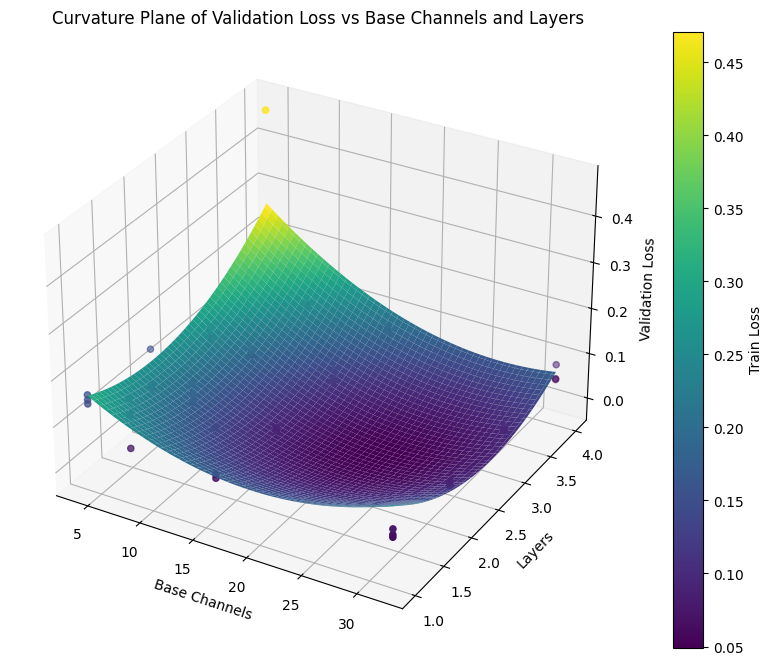

In [ ]:
import numpy as np
from scipy.optimize import curve_fit


with open('grid_search_results_autoencoder.json', 'r') as f:
    results = json.load(f)

epochs = []
base_channels = []
layers = []
train_losses = []
val_losses = []

for result in results:
    #if result['epoch'] != 3:
    #  continue
    epochs.append(result['epoch'])
    base_channels.append(result['base_channels'])
    layers.append(result['layers'])
    train_losses.append(result['train_loss'])
    val_losses.append(result['val_loss'])

# Define a quadratic function
def quadratic_func(x, a, b, c, d, e, f):#, g, h, i, j, k):
    return a * x[0]**2 + b * x[1]**2 + c * x[0] * x[1] + d * x[0] + e * x[1] + f #+ g * x[0]**3 + h * x[1]**3 + i * x[0]**2 * x[1] + j * x[0] * x[1]**2 + k * x[0]**2 * x[1]**2


# Convert lists to numpy arrays for curve fitting
base_channels_arr = np.array(base_channels)
layers_arr = np.array(layers)
train_losses_arr = np.array(val_losses)

# Fit the quadratic function to the loss values
popt, _ = curve_fit(quadratic_func, (base_channels_arr, layers_arr), train_losses_arr)

# Create a grid of base_channels and layers values
base_channels_grid, layers_grid = np.meshgrid(np.linspace(min(base_channels_arr), max(base_channels_arr), 100),
                                              np.linspace(min(layers_arr), max(layers_arr), 100))

# Calculate predicted train losses using the fitted quadratic function
train_losses_predicted = quadratic_func((base_channels_grid, layers_grid), *popt)

# Plot the curvature plane
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(base_channels_grid, layers_grid, train_losses_predicted, cmap='viridis')

# Add scatter plot of actual train losses
sc = ax.scatter(base_channels_arr, layers_arr, train_losses_arr, c=train_losses_arr, cmap='viridis', marker='o')

ax.set_xlabel('Base Channels')
ax.set_ylabel('Layers')
ax.set_zlabel('Validation Loss')
plt.title('Curvature Plane of Validation Loss vs Base Channels and Layers')

# Adding a color bar
cbar = plt.colorbar(sc)
cbar.set_label('Train Loss')

plt.show()


0.90737647 0.056747343


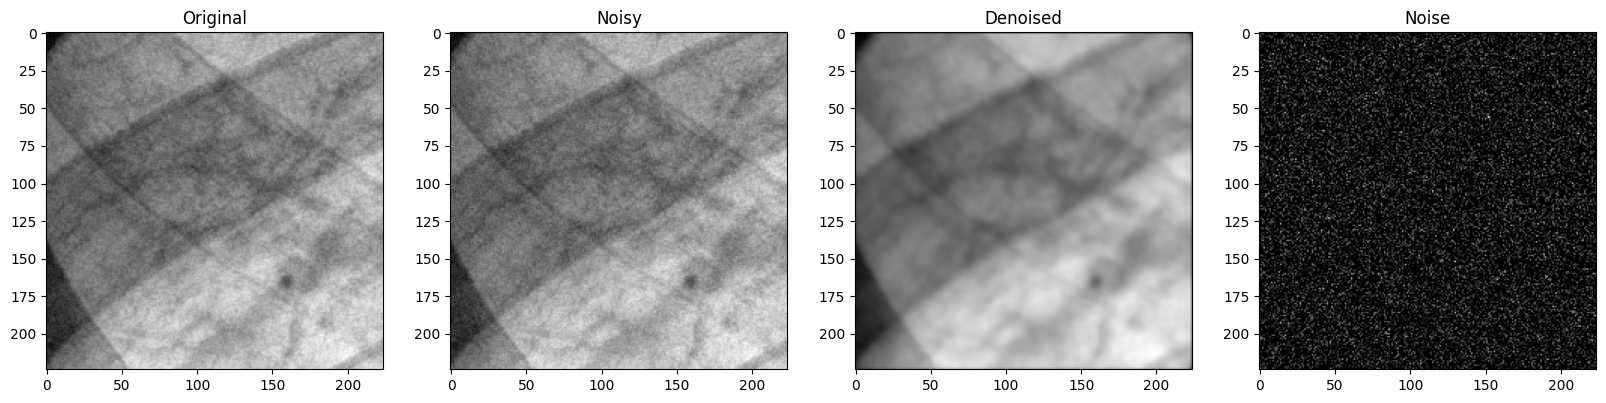

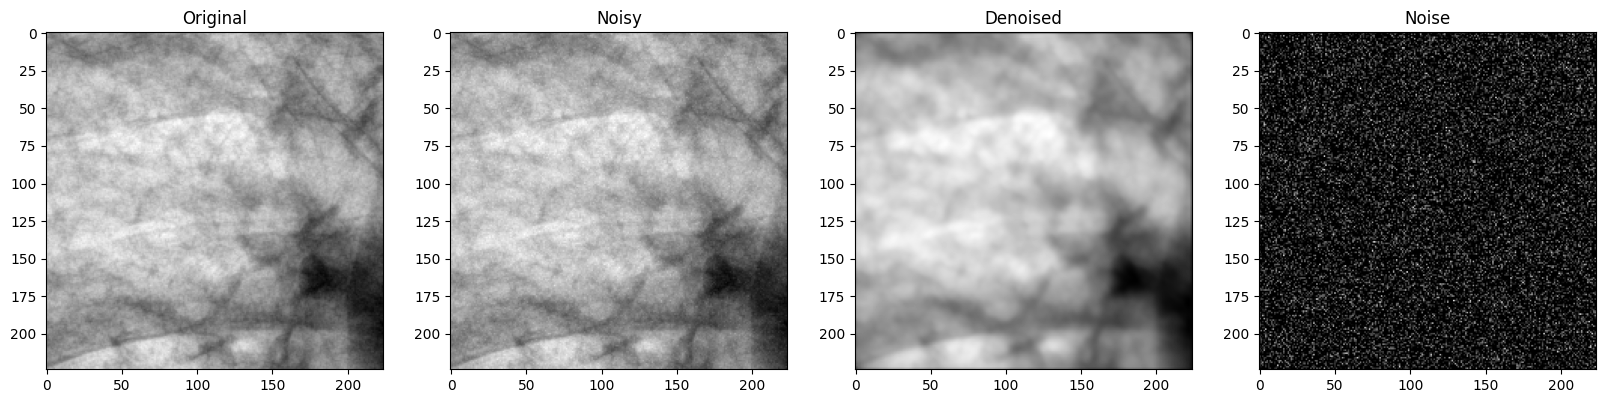

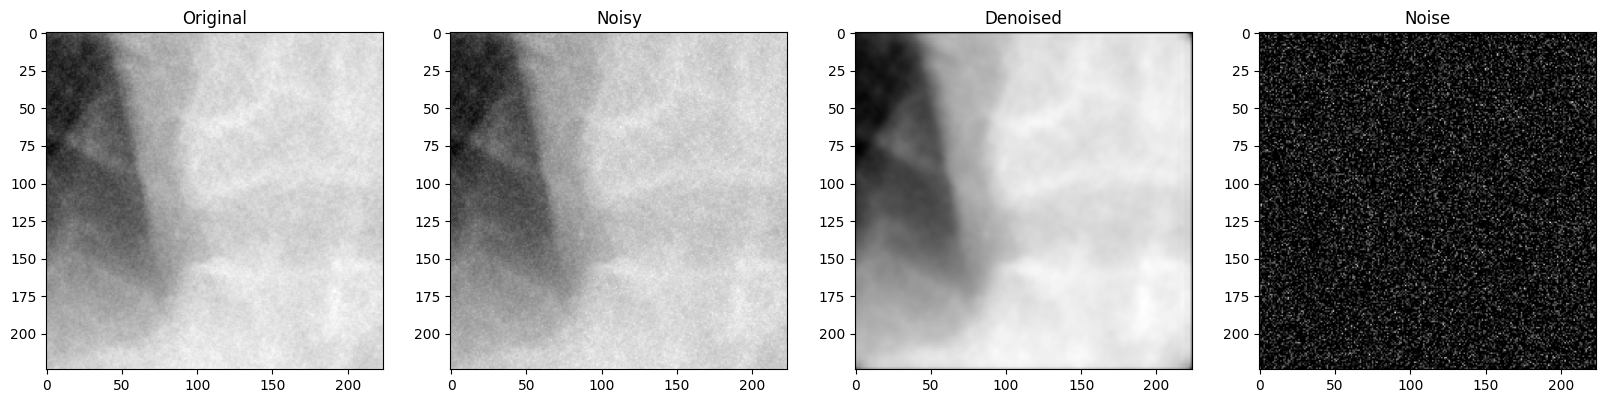

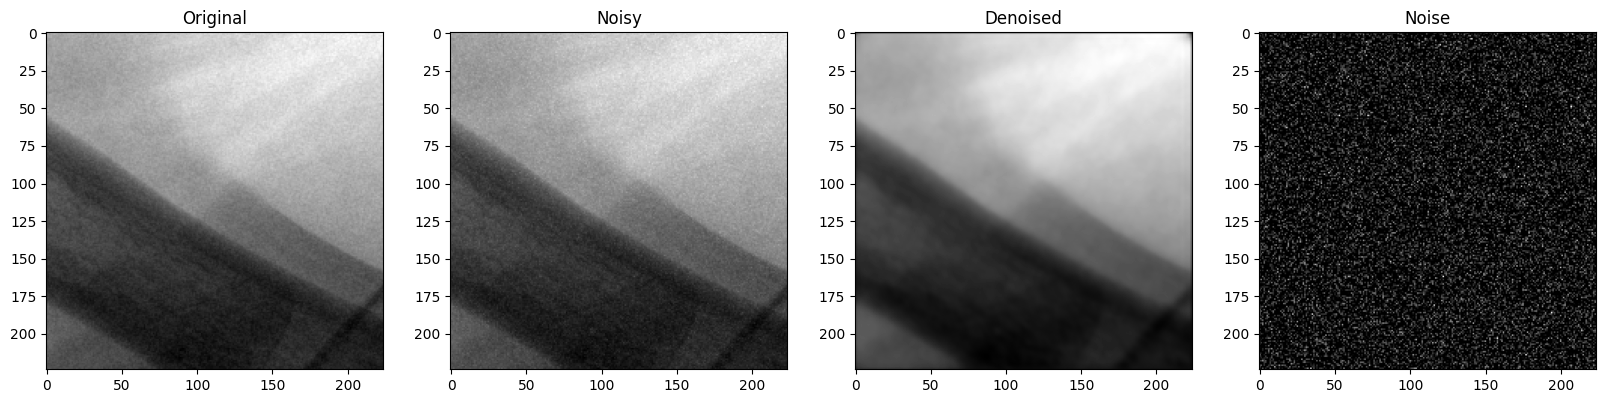

In [ ]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    for i, (img, noisy_img, noise) in enumerate(test_lodaer):
        output = model(noisy_img)
        img = img.cpu().numpy()
        noisy_img = noisy_img.cpu().numpy()
        output = output.cpu().numpy()
        noise = noise.cpu().numpy()
        print(output[0, 0, :, :].max(), output[0, 0, :, :].min())
        for j in range(4):
            fig, axs = plt.subplots(1, 4, figsize=(20, 20))
            axs[0].imshow(img[j, 0, :, :], cmap='gray')
            axs[0].set_title('Original')
            axs[1].imshow(noisy_img[j, 0, :, :], cmap='gray')
            axs[1].set_title('Noisy')
            axs[2].imshow(output[j, 0, :, :], cmap='gray')
            axs[2].set_title('Denoised')
            axs[3].imshow(noise[j,0, :, :], cmap='gray')
            axs[3].set_title('Noise')
            plt.show()
        break # one iter


In [ ]:
# save
torch.save(model, 'unet_without_rot.pth')

In [ ]:
!gdown https://drive.google.com/drive/folders/1LPVMUAtHU4phbYxKrkMJfK5Gehn3OcJi?usp=sharing --folder

Retrieving folder contents
Processing file 10BZrdvjMA7nUv7BTgwhTninoXiFVUrjs example.png
Processing file 1c73Ggy4WnDkOFaLSIybLThDbx_AzGpOA l1_unet_model.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=10BZrdvjMA7nUv7BTgwhTninoXiFVUrjs
To: /content/medicinske/example.png
100% 6.86M/6.86M [00:00<00:00, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c73Ggy4WnDkOFaLSIybLThDbx_AzGpOA
To: /content/medicinske/l1_unet_model.pth
100% 2.30M/2.30M [00:00<00:00, 158MB/s]
Download completed


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
import numpy as np
from PIL import Image

img = Image.open('medicinske/example.png')
trans = transforms.Compose([transforms.ToTensor()])
img = trans(img)

img = (img - img.min()) / (img.max() - img.min())
# img crop to multiple of 32
img = img[:, :img.shape[1]//32*32, :img.shape[2]//32*32]
out = None
with torch.no_grad():
    out = model(img.unsqueeze(0).to(device))

img = img.squeeze().cpu().numpy()
out = out.squeeze().cpu().numpy()

print("PSNR", psnr(img, out))
print("structural_similarity: ", ssim(img,out))
print("mean_squared_error", mean_squared_error(img, out))


out = Image.fromarray(np.uint8(out*255))
out.save('medicinske/example_output_unet_5_4.png')

PSNR 45.25749266066364
structural_similarity:  0.994122962911573
mean_squared_error 2.9802365313302897e-05


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as snr
from skimage.metrics import mean_squared_error as mean_squared_error
snr_img = 0
snr_output = 0
ssi = 0
mse = 0
count = 0

t = tqdm(test_lodaer)
model.eval()
with torch.no_grad():
    for i, (img, noisy_img, noise) in enumerate(t):
        output = model(noisy_img)
        imgs = img.squeeze().cpu().numpy()
        outputs = output.squeeze().cpu().numpy()
        for img, output in zip(imgs, outputs):
            snr_img += snr(img, output)
            #snr_output += snr(output)
            ssi += ssim(img, output)
            mse += mean_squared_error(img, output)
            count += 1
print("PSNR: ", snr_img / count)
print("SSIM: ", ssi / count)
print("MSE", mse / count )


  0%|          | 0/26 [00:00<?, ?it/s]

PSNR:  28.652972358995484
structural_similarity:  0.8332081106975554
mean_squared_error 0.001551192391397598


In [ ]:
import torch
device = torch.device('cpu')
model = torch.load('unet_without_rot.pth', map_location=device)

In [ ]:
import leafmap
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
import numpy as np
from PIL import Image

img = np.array( Image.open('example.png'), np.float32)
img = (img - img.min()) / (img.max() - img.min())
# img crop to multiple of 32

x,y = img.shape[0], img.shape[1]
noise = noise_gen.noise(x,y)
noisy_img = img + noise # Generate "noisy img"

trans = transforms.Compose([transforms.ToTensor()])
noisy_img = trans(noisy_img)
out = None
with torch.no_grad():
    out = model(noisy_img.unsqueeze(0).to(device))

noisy_img = noisy_img.squeeze().cpu().numpy()
out = out.squeeze().cpu().numpy()
noisy_img = np.clip(noisy_img,0,1)
out = np.clip(out,0,1)

print("PSNR", psnr(img, out))
print("SSIM: ", ssim(img,out, data_range=1))
print("MSE", mean_squared_error(img, out))

out = Image.fromarray(np.uint8(out*255))
out.save('example_output_unet_5_4.png')
noisy_img = Image.fromarray(np.uint8(noisy_img*255))
noisy_img.save('example_n.png')


leafmap.image_comparison(
    "example_n.png",
    "example_output_unet_5_4.png",
    label1="Original Image",
    label2="Denoised",
    starting_position=50,
    out_html="image_comparison.html",
)